# Семинар 2

## Изучаем градиентный спуск

In [1]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt
import abc

import numpy as np
import pandas as pd
from numpy import linalg
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import time

Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

Mean Squared Error в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$


Градиент для MSE будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс BaseLoss, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:

Метод calc_loss, который будет принимать на вход объекты x, правильные ответы y и веса w и вычислять значения лосса
Метод calc_grad, который будет принимать на вход объекты x, правильные ответы y и веса w и вычислять значения градиента (вектор)
abc. abstractmethod – декоратор, который указывает, что метод является абстрактным. Этот декоратор применяется к методу внутри абстрактного класса. Класс, который наследует свойства и методы от абстрактного класса, должен реализовать все абстрактные методы, иначе он также будет считаться абстрактным.

Декораторы в Python — это функции, которые принимают другую функцию в качестве аргумента, добавляют к ней некоторую дополнительную функциональность и возвращают функцию с измененным поведением.



In [2]:
class BaseLoss(abc.ABC):
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

✅ Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по приведенным формулам 

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$


$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        Q = ((linalg.norm(np.dot(X,w) - y))**2)/len(y)
        return Q
        
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        L = np.dot(X,w) - y
        Xt = np.transpose(X)
        Grad = 2*np.dot(Xt, L)/len(y)
        return Grad

Можете создать объект `MSELoss` и при помощи него вычислять значение функции потерь и градиенты (проведите проверку корректности реализации кода):

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


✅ Реализуйте функцию `gradient_descent`

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$


In [5]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    W = []
    
    for i in range(n_iterations):
        w_init_new = w_init - lr*loss.calc_grad(X, y, w_init)
        W.append(w_init_new)
        w_init = w_init_new
        
    return W
   

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))



X = np.random.uniform(-5, 5, (n_objects, n_features))

X = X * (np.arange(n_features) * 2 + 1)[np.newaxis, :]  


y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

✅ Создайте экземпляр класса MSELoss(), посомтрите на ошибку на первом и последнем шаге

In [7]:
loss = MSELoss()

In [8]:
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)

In [9]:
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.26258214352066
0.8670644395649502


Создали экземпляр класса MSELoss(), посомтрели на ошибку на первом и последнем шаге

In [10]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

✅ При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага . 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска


длина шага 0.0001


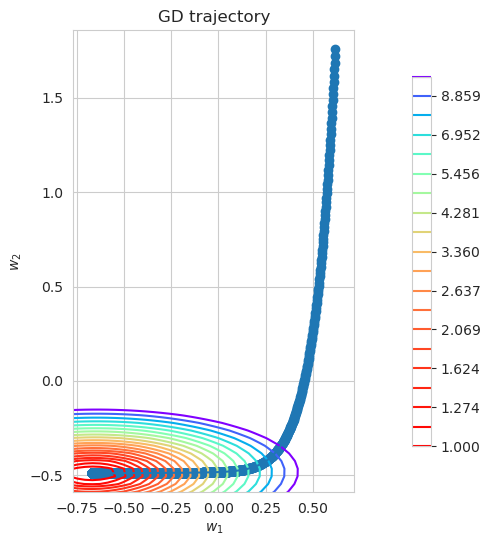

длина шага 0.001


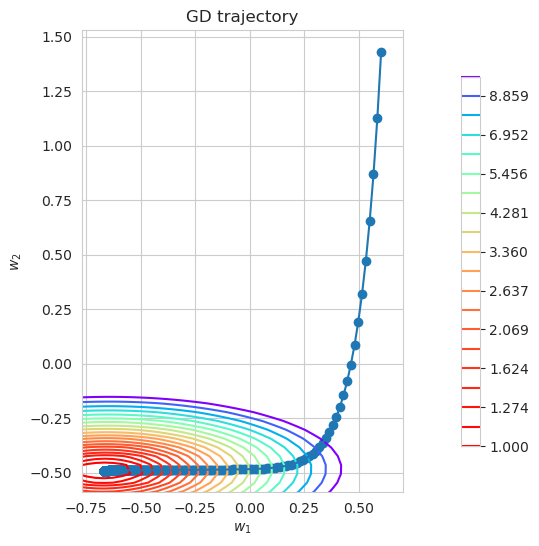

длина шага 0.01


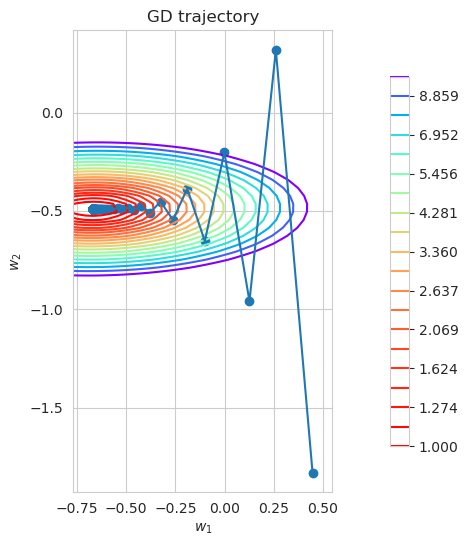

In [11]:
lr = [0.0001, 0.001, 0.01]

for i in range(len(lr)):
    w_list = gradient_descent(w_init, X, y, loss, lr[i])
    print('длина шага', lr[i])
    plot_gd(w_list, X, y, loss)

✅ Реализуйте функцию `stochastic_gradient_descent`

In [12]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    W = []
    
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace = False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new
        
    return W

✅ При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага и размера подвыборки. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?


batch_size =  1 , lr =  0.0001
 --- 0.0269930362701416 seconds ---


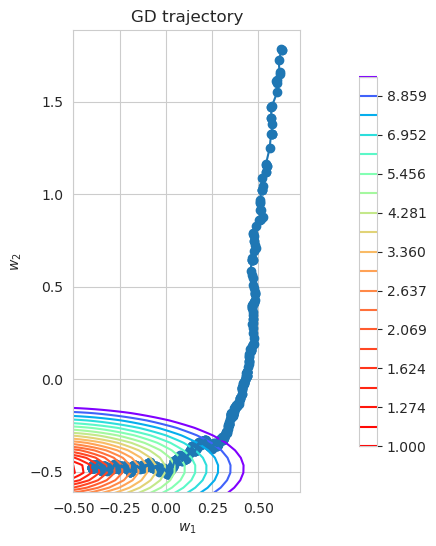

batch_size =  1 , lr =  0.001
 --- 0.020859479904174805 seconds ---


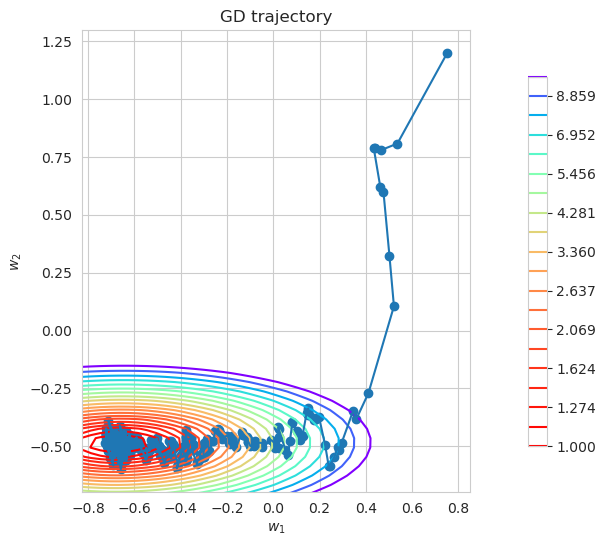

batch_size =  1 , lr =  0.01
 --- 0.019379854202270508 seconds ---


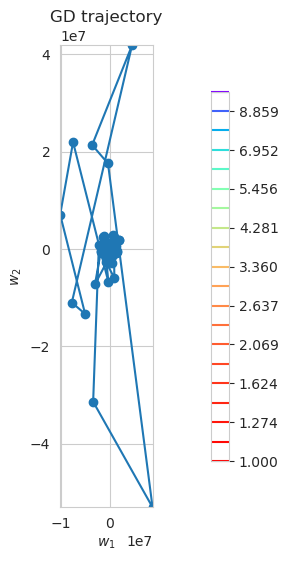

batch_size =  10 , lr =  0.0001
 --- 0.019829750061035156 seconds ---


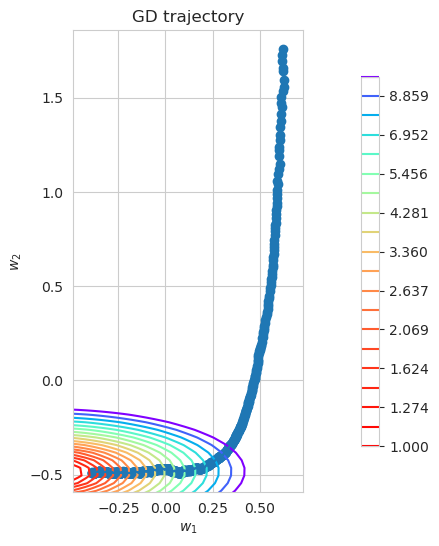

batch_size =  10 , lr =  0.001
 --- 0.020657777786254883 seconds ---


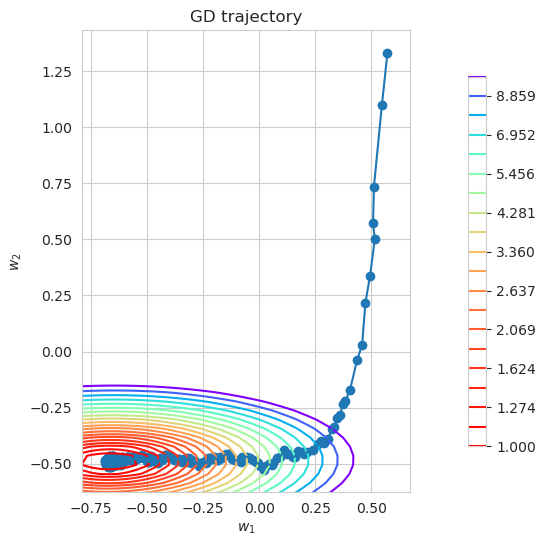

batch_size =  10 , lr =  0.01
 --- 0.02158355712890625 seconds ---


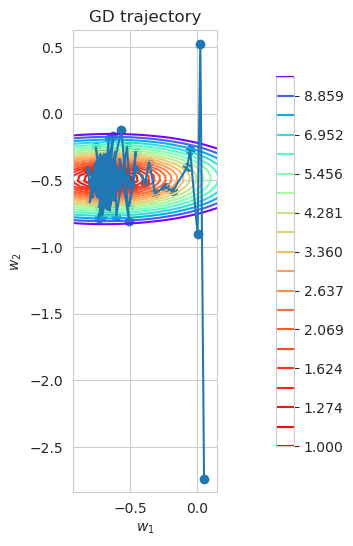

batch_size =  100 , lr =  0.0001
 --- 0.02135157585144043 seconds ---


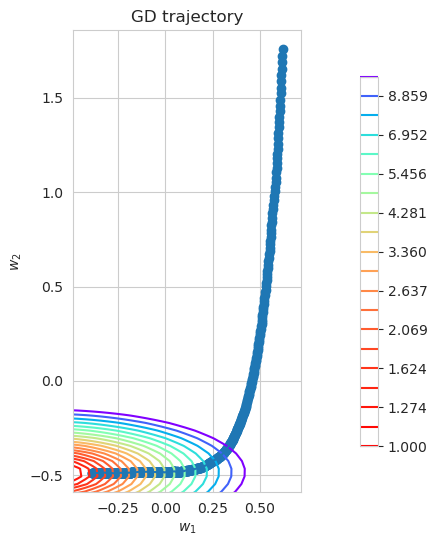

batch_size =  100 , lr =  0.001
 --- 0.022553443908691406 seconds ---


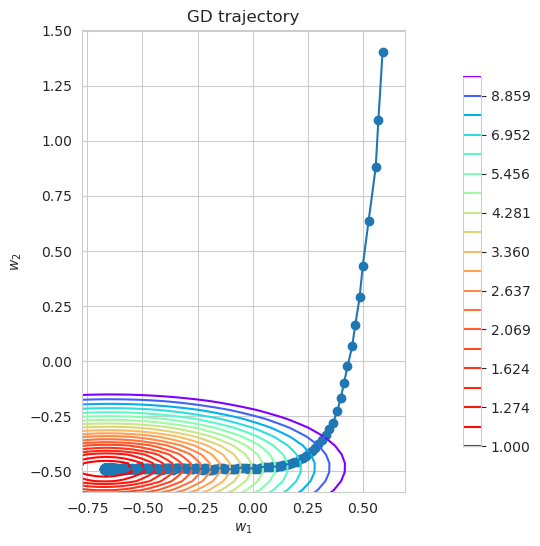

batch_size =  100 , lr =  0.01
 --- 0.02146148681640625 seconds ---


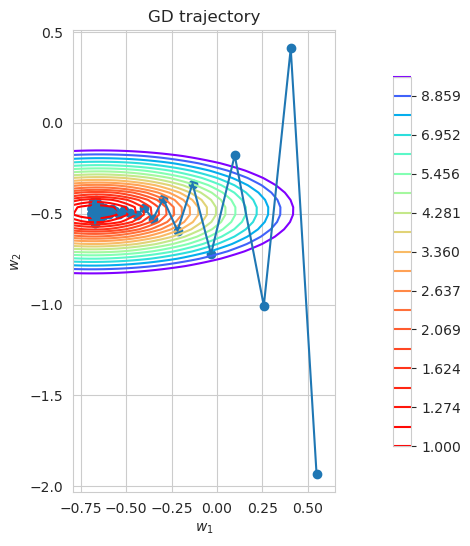

batch_size =  200 , lr =  0.0001
 --- 0.02342844009399414 seconds ---


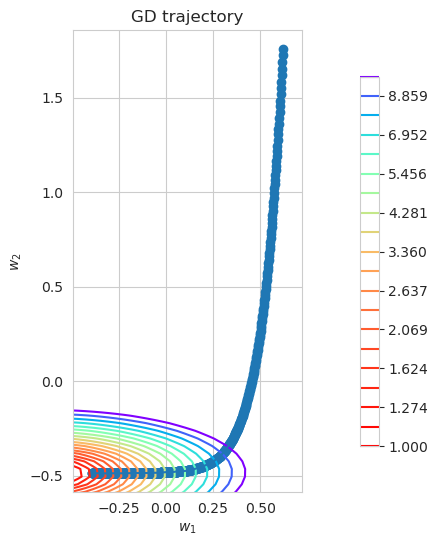

batch_size =  200 , lr =  0.001
 --- 0.02214813232421875 seconds ---


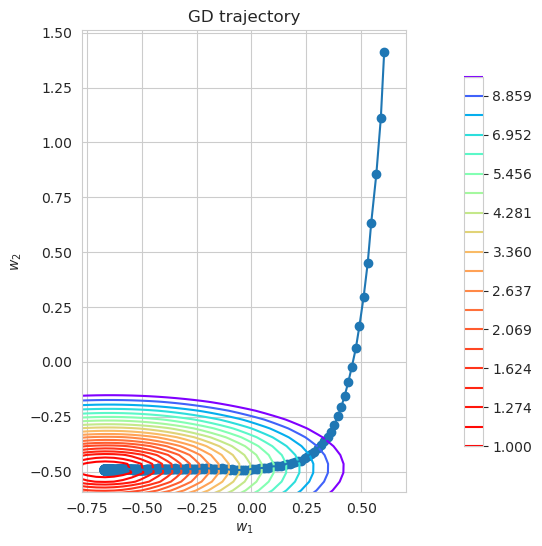

batch_size =  200 , lr =  0.01
 --- 0.022386789321899414 seconds ---


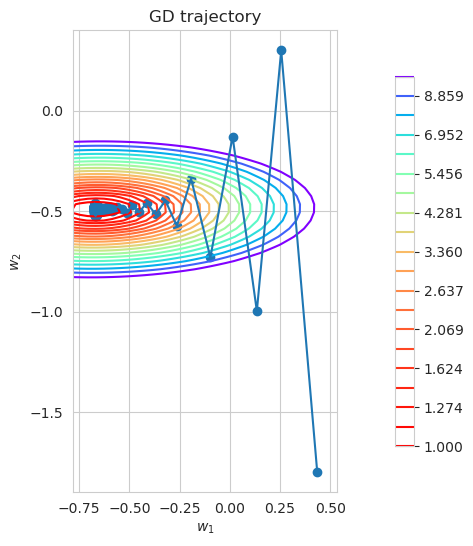

In [13]:
lr = [0.0001, 0.001, 0.01]
batch_size = [1, 10, 100, 200]

for j in range(len(batch_size)):
    for i in range(len(lr)):
        start_time = time.time()
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr[i], batch_size[j])
        print('batch_size = ', batch_size[j], ',', 'lr = ', lr[i])
        print(" --- %s seconds ---" % (time.time() - start_time))
        plot_gd(w_list, X, y, loss)

Затухающий шаг в градиентном спуске:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$


✅ Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [14]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    s0 = 1
    W = []
    
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        w_init_new = w_init - lr*((s0/(s0 + i))**p)*loss.calc_grad(X_batch, y_batch, w_init)
        W.append(w_init_new)
        w_init = w_init_new
        
    return W

✅ При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. 

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

p =  0.1


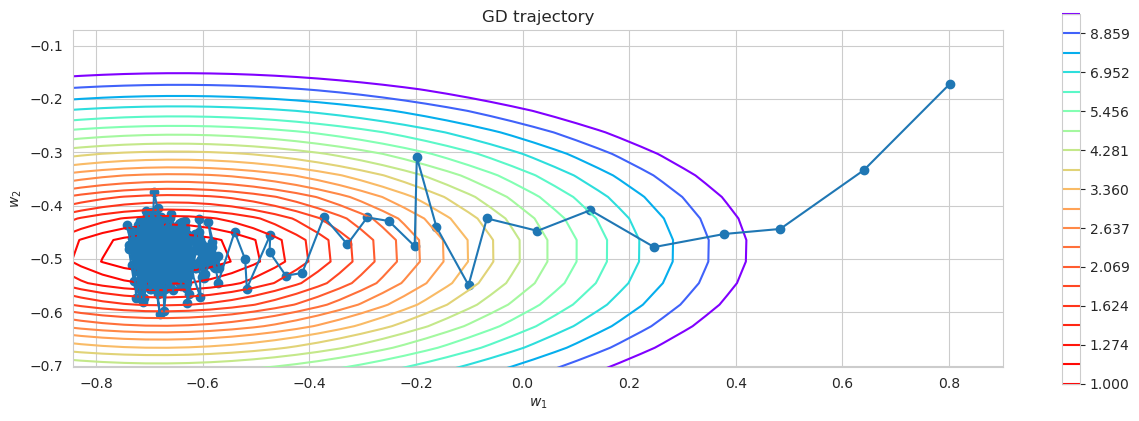

p =  0.3


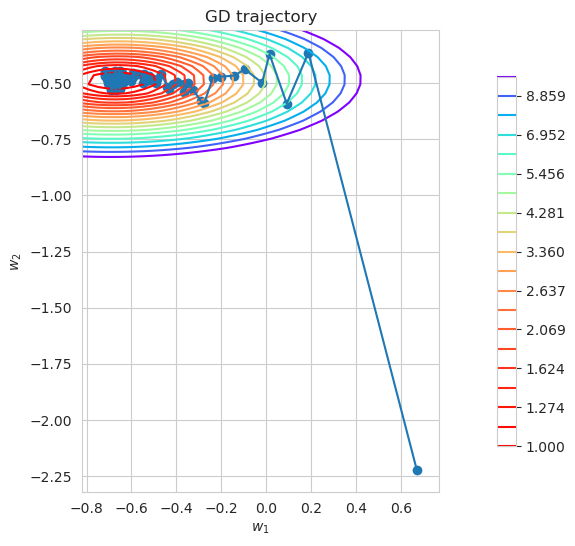

p =  0.6


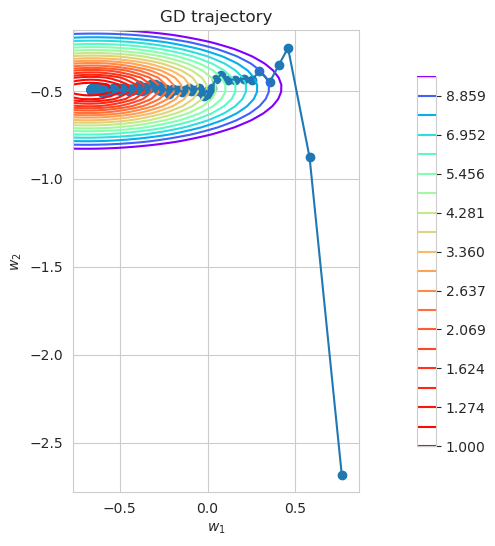

p =  0.9


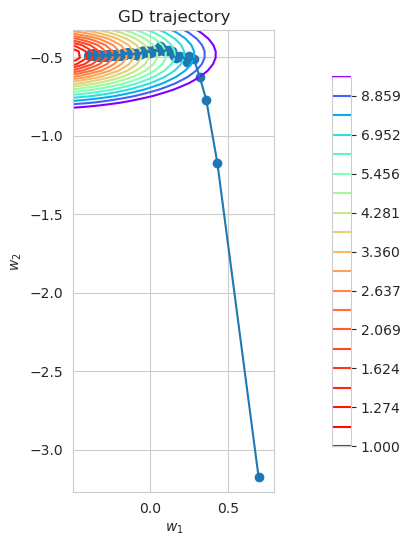

In [15]:
p = [0.1, 0.3, 0.6, 0.9]

for i in range(len(p)):
    w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = p[i])
    print('p = ', p[i])
    plot_gd(w_list, X, y, loss)

In [16]:
# чем больше p, тем быстрее затухает шаг, потому что в знаменателе степень больше, чем в числителе

✅ Сравните сходимость обычного градиентного спуска и стохастичекой версии:

Видно ли на данном графике преимущество SGD? 

In [17]:
k_sgd = []
sgd = []
loss = MSELoss()

w_list = stochastic_gradient_descent(w_init, X, y, loss, lr=0.01, batch_size=10, p = 0.1, n_iterations=100)
for i in range(len(w_list)):
    losses_sgd = loss.calc_loss(X, y, w_list[i])
    sgd.append(losses_sgd)
    k_sgd.append(i)
    
    
k_gd = []
gd = []
loss = MSELoss()

w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
for i in range(len(w_list)):
    losses_gd = loss.calc_loss(X, y, w_list[i])
    gd.append(losses_gd)
    k_gd.append(i)

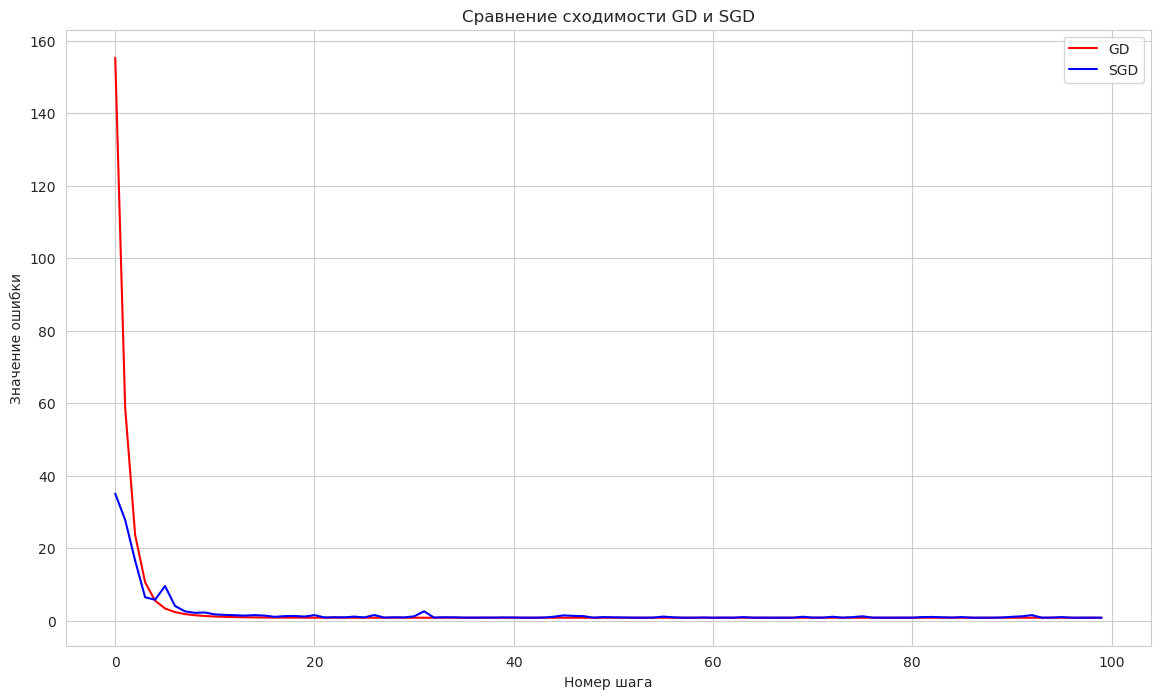

In [23]:
x1 = k_gd
x2 = k_sgd

fig, ax = plt.subplots(figsize=(14,8))

y1 = gd
y2 = sgd

ax.plot(x1, y1, color = 'red', label = 'GD')
ax.plot(x2, y2, color = 'blue', label = 'SGD')

ax.grid(True)
ax.legend()

plt.xlabel("Номер шага")
plt.ylabel("Значение ошибки")
plt.title("Сравнение сходимости GD и SGD")
plt.show()

## Линейная регрессия

✅ Допишите код в методах `fit` и `predict` класса `LinearRegression`

In [24]:
class LinearRegression1:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None
        self.g = None

    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        
        # добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        shape_X = X.shape
        
        # иниц. веса
        self.w = np.arange(shape_X[-1])
        self.g = gradient_descent(self.w, X, y, self.loss, lr = self.lr, n_iterations = 100000)
        return self.g[-1]
        
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        assert hasattr(self, "g"), "Linear regression must be fitted first"
        
        # добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        y = np.dot(X, self.g[-1])
        
        
        return y

✅ Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [25]:
linear_regression = LinearRegression1(MSELoss())

✅ Загрузим датасет по ссылке

In [28]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None, 
    na_values=["?"]
)

In [29]:
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [30]:
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [31]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

✅ Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:


* Заполните пропуски
* Закодируйте категориальные переменные
* Нормализуйте числовые признаки
* Разделите датасет на обучающую и тестовую выборку


Есть ли в данных пропуски?

In [34]:
X_raw.isnull().any().any()

np.True_

In [35]:
nulls = X_raw.isnull().sum()
nulls = nulls[nulls>0]
nulls

1     37
5      2
18     4
19     4
21     2
22     2
dtype: int64

In [36]:
for col in X_raw:
    if X_raw[col].isnull().sum() > 0:
        print(col, ":", X_raw[col].dtypes)

1 : float64
5 : object
18 : float64
19 : float64
21 : float64
22 : float64


In [37]:
X_raw[1] = X_raw[1].fillna(X_raw[1].mean())

In [38]:
X_raw[5].value_counts()

5
four    113
two      86
Name: count, dtype: int64

In [39]:
X_raw[5] = X_raw[5].fillna('four')

In [40]:
columns = [18,19,21,22]

for column in columns:
    print(column)
    print(mode(X_raw[column])[0])
    X_raw[column] = X_raw[column].fillna(mode(X_raw[column])[0])

18
3.62
19
3.4
21
68.0
22
4800.0


Избавились ли мы от пропусков?

In [41]:
X_raw.isnull().any().any()

np.False_

**Кодирование призанков**

In [42]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   201 non-null    int64  
 1   0       201 non-null    int64  
 2   1       201 non-null    float64
 3   2       201 non-null    object 
 4   3       201 non-null    object 
 5   4       201 non-null    object 
 6   5       201 non-null    object 
 7   6       201 non-null    object 
 8   7       201 non-null    object 
 9   8       201 non-null    object 
 10  9       201 non-null    float64
 11  10      201 non-null    float64
 12  11      201 non-null    float64
 13  12      201 non-null    float64
 14  13      201 non-null    int64  
 15  14      201 non-null    object 
 16  15      201 non-null    object 
 17  16      201 non-null    int64  
 18  17      201 non-null    object 
 19  18      201 non-null    float64
 20  19      201 non-null    float64
 21  20      201 non-null    float64
 22  21

In [43]:
columns = [3,4,5,8]

for col in columns:
    print(X_raw[col].unique())

['gas' 'diesel']
['std' 'turbo']
['two' 'four']
['front' 'rear']


In [44]:
for col in columns:
    X_raw[col] = LabelEncoder().fit_transform(X_raw[col])

In [45]:
X_raw = X_raw.drop('index', axis = 1)

In [46]:
cat_mask = X_raw.select_dtypes(include=['object']).columns

In [47]:
X_raw = pd.get_dummies(X_raw, columns=cat_mask, drop_first=True)

In [48]:
X_raw.columns

Index([                0,                 1,                 3,
                       4,                 5,                 8,
                       9,                10,                11,
                      12,                13,                16,
                      18,                19,                20,
                      21,                22,                23,
                      24,          '2_audi',           '2_bmw',
           '2_chevrolet',         '2_dodge',         '2_honda',
               '2_isuzu',        '2_jaguar',         '2_mazda',
       '2_mercedes-benz',       '2_mercury',    '2_mitsubishi',
              '2_nissan',        '2_peugot',      '2_plymouth',
             '2_porsche',       '2_renault',          '2_saab',
              '2_subaru',        '2_toyota',    '2_volkswagen',
               '2_volvo',       '6_hardtop',     '6_hatchback',
               '6_sedan',         '6_wagon',           '7_fwd',
                 '7_rwd',            '14

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_raw.columns = X_raw.columns.astype(str)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3)

In [53]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((140, 64), (140,), (61, 64), (61,))

In [56]:
from sklearn.preprocessing import StandardScaler

In [57]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

✅ Обучите написанную вами линейную регрессию на обучающей выборке

In [58]:
lin_reg = LinearRegression1(MSELoss(), lr=0.01)
lin_reg.fit(X_train, y_train)

array([-4.72132996e+02, -3.35778229e+02, -1.67038601e+03,  9.88149509e+02,
        2.23393699e+02,  5.00000000e+00,  1.52602398e+03, -1.55516378e+03,
        6.72980754e+02, -1.15775458e+03,  4.45538854e+03,  9.90503506e+03,
       -4.26361997e+03, -1.31959754e+03, -2.97202769e+03, -6.46172928e+02,
        1.05683869e+03, -1.47032365e+03,  1.82645168e+03,  9.91147896e+02,
        2.05489190e+03, -9.27031817e+01, -3.53852774e+02,  2.79897207e+02,
       -1.07132754e+02, -4.97779986e+02,  5.41937557e+02,  4.66741430e+02,
        2.20583219e+02, -3.78948662e+02,  3.66392847e+02, -5.69414747e+02,
       -3.36970281e+02,  8.87517792e+02,  2.35778694e+02,  1.24912042e+03,
        5.76913200e+02,  3.07634555e+02,  4.47272880e+02,  6.30389353e+02,
       -6.89574886e+01, -1.73889534e+03, -1.24482181e+03, -9.56018179e+02,
       -4.06050238e+02,  1.41625977e+02,  6.00268953e+01,  3.42119111e+02,
        5.88913200e+02, -4.20230624e+02,  2.06960743e+03,  1.05554135e+03,
        4.85916952e+03,  

✅ Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке 

In [59]:
print("MSE train", mean_squared_error(y_train, lin_reg.predict(X_train)))
print("MSE test", mean_squared_error(y_test, lin_reg.predict(X_test)))

MSE train 1487127.8359518936
MSE test 12358309.753041534


✅ Реализуйте класс `MSEL2Loss`

MSE с L2 регуляризацией:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

В матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$


Градиент:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

In [60]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # ВАЖНО! последний элемент вектора w — это bias (колонка из единиц — константный признак),
        # bias регуляризовать не нужно! Уберем последний элемент из w при подсчете слагаемого lambda||w||^2
        Q = ((linalg.norm(np.dot(X,w) - y))**2)/len(y) + self.coef*linalg.norm(w[:-1])**2
        return Q
        
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        L = np.dot(X,w)-y
        Xt = np.transpose(X)
        #w = np.append(w[:-1], 0)
        Grad = 2*np.dot(Xt, L)/len(y) + 2*self.coef*w
        return Grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [61]:
linear_regression = LinearRegression1(MSEL2Loss(0.1))

✅ Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [62]:
alphas = [10, 1, 0.1, 0.01, 0.001, 0.0001]

model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print('best alpha = ', grid.best_estimator_.alpha)
print('MSE test ', mean_squared_error(y_test, grid.predict(X_test)))

best alpha =  10
MSE test  8825071.767533444


✅ Реализуйте класс `HuberLoss`

Функция потерь Huber Loss:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


Градиент:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
             
 

✅ Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

Создадим новый класс для удобства:

In [ ]:
class LinearRegression2:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None
        self.g = None

    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
       pass
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass

**Обучаем регрессию с MSELoss:**

**Обучаем регрессию с HuberLoss:**

**Сравним:**